In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTextModel, CLIPTokenizer, CLIPFeatureExtractor
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, EulerDiscreteScheduler, PNDMScheduler
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchinfo import summary
from accelerate import Accelerator

TRANS_MODEL = "openai/clip-vit-large-patch14"
DIFF_MODEL = "CompVis/stable-diffusion-v1-4"
image_path = "img.png"
dtype=torch.float16

In [2]:
class NeRFDataset(Dataset):
    def __init__(self, arrays):
        self.data = [self.flatten_array(arr) for arr in arrays]
        self.data = np.array(self.data)
        self.input_dim = len(self.data[0])
    
    def flatten_array(self, array):
        flattened = np.concatenate([arr.flatten() for arr in array])
        return flattened

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=dtype)
    
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
                
# 단일 이미지와 프롬프트를 사용하는 데이터셋 클래스 정의
class SingleImageDataset(Dataset):
    def __init__(self, image_path, prompt, H):
        self.image = Image.open(image_path).convert("RGB")
        self.prompt = prompt
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
            transforms.Resize((H, H)),
            transforms.ToTensor()
        ])


    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = self.transform(self.image)
        return {"image": image, "prompt": self.prompt}
    
def plt_img(img):
    img = img.permute(1, 2, 0).to('cpu').detach().numpy()
    img = np.clip(img, 0, 1).astype(np.float32)
    plt.imshow(img)
    plt.show()

def make_image(pth, H):
    tr = transforms.Compose([
            transforms.Resize((H, H)),
            transforms.ToTensor()
        ])
    im = Image.open(pth).convert("RGB")
    im = tr(im)
    im = im.unsqueeze(0).to('cuda')
    
    return im

In [3]:
# fern = np.load('fern.npy', allow_pickle=True)
# lego = np.load('lego.npy', allow_pickle=True)
# dataset = NeRFDataset([fern, lego])
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
class CustomEncoder(nn.Module):
    def __init__(self, original_encoder):
        super().__init__()
        self.original_encoder = original_encoder
        self.custom_layer = nn.Conv2d(in_channels=original_encoder.conv_out.out_channels, 
                                      out_channels=original_encoder.conv_out.out_channels, 
                                      kernel_size=3, padding=1)

    def forward(self, x):
        x = self.original_encoder(x)
        # x = self.custom_layer(x)
        return x

class CustomDecoder(nn.Module):
    def __init__(self, original_decoder):
        super().__init__()
        self.original_decoder = original_decoder
        self.custom_layer = nn.Conv2d(in_channels=original_decoder.conv_in.in_channels, 
                                      out_channels=original_decoder.conv_in.in_channels, 
                                      kernel_size=3, padding=1)

    def forward(self, x):
        x = self.original_decoder(x)
        # x = self.custom_layer(x)
        return x


In [5]:
text_encoder = CLIPTextModel.from_pretrained(TRANS_MODEL)
tokenizer = CLIPTokenizer.from_pretrained(TRANS_MODEL)
feature_extractor = CLIPFeatureExtractor.from_pretrained(TRANS_MODEL)


# d = {
#     "beta_end": 0.012,
#     "beta_schedule": "scaled_linear",
#     "beta_start": 0.00085,
#     "num_train_timesteps": 1000,
#     "set_alpha_to_one": False,
#     "skip_prk_steps": True,
#     "steps_offset": 1,
#     "trained_betas": None,
# }
# scheduler = EulerDiscreteScheduler.from_pretrained(DIFF_MODEL, subfolder="scheduler")
scheduler = PNDMScheduler.from_pretrained(DIFF_MODEL, subfolder="scheduler", torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(DIFF_MODEL, subfolder="unet", torch_dtype=dtype)

vae = AutoencoderKL.from_pretrained(DIFF_MODEL, subfolder="vae", torch_dtype=dtype)
vae.encoder = CustomEncoder(vae.encoder)
vae.decoder = CustomDecoder(vae.decoder)
# vae.apply(initialize_weights)

# Stable Diffusion Pipeline 초기화
# pipe = StableDiffusionPipeline(
#     vae=vae,
#     text_encoder=text_encoder,
#     tokenizer=tokenizer,
#     unet=unet,
#     scheduler=scheduler,
#     safety_checker=None,
#     feature_extractor=feature_extractor, 
#     image_encoder=None,
#     requires_safety_checker=False, 
# )
pipe = StableDiffusionPipeline.from_pretrained(DIFF_MODEL, torch_dtype=dtype)
# pipe.vae = vae
# pipe.unet = unet
# pipe.scheduler = scheduler

pipe = pipe.to("cuda")
# 
# for param in pipe.unet.parameters():
#     param.requires_grad = False
# 
# for param in pipe.text_encoder.parameters():
#     param.requires_grad = False

C:\Users\dinle\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\dinle\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(pipe.vae.parameters(), lr=1e-4)
accelerator = Accelerator()

In [10]:
prompt = "Baby Cat"
H = 512
W = H
dataset = SingleImageDataset(image_path, prompt, H)
dataloader = DataLoader(dataset, batch_size=1)
img_real = make_image(image_path, H)

In [11]:
model, optimizer, training_dataloader, scheduler = accelerator.prepare(
     pipe, optimizer, dataloader, scheduler
)

  0%|          | 0/50 [00:00<?, ?it/s]

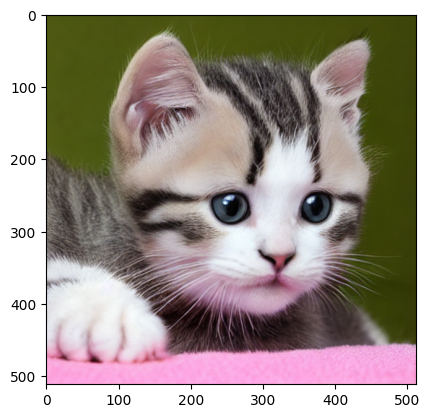

In [12]:
with torch.no_grad():
    result = pipe(prompt, height =H, width=W, output_type='pt')
    img_gen = result.images
    plt_img(img_gen[0])
    

In [ ]:
with torch.no_grad():
    latents_org = pipe.vae.encode(img_real).latent_dist.sample() 
    
init = False

num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        prompt = batch["prompt"]

        # VAE를 사용하여 이미지 인코딩 및 디코딩
        # with torch.enable_grad():  # VAE에서만 그래디언트를 허용
        #     # VAE를 사용하여 이미지 인코딩 및 디코딩
        if not init:
            vae.apply(initialize_weights)
            init = True
        
        latents = pipe.vae.encode(img_real).latent_dist.sample()

        img_rec = pipe.vae.decode(latents).sample
        print('Recon')
        plt_img(img_rec[0])
        
        # result = pipe(prompt, height =H, width=W, output_type='pt')
        # img_gen = result.images
        # latents_gen = result.latents[0]
        
        # print('Gen')
        # plt_img(img_gen[0])
        
        # 손실 계산 및 역전파
        loss_enc = criterion(latents, latents_org)
        loss_dec = criterion(img_rec, img_real)
        # loss_pipe = criterion(img_gen, img_real)
        
        loss = loss_enc + loss_dec 
        accelerator.backward(loss)
        optimizer.step()
        
        del img_rec
        # del img_gen
        del latents
        # del latents_gen
        torch.cuda.empty_cache()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

In [ ]:
with torch.no_grad():
    img_rec = vae(img_real)
    plt_img(img_rec[0][0])

In [ ]:
img2 = make_image('img2.png',H)
with torch.no_grad():
    img_rec2 = vae(img2)
    plt_img(img_rec2[0][0])